In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import random
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5,0.5,0.5))
])
common_kwargs_set = {
    "root":os.path.abspath('.').split(os.path.sep)[0]+os.path.sep+"cifardata",
    "transform":transform,
    "download":True}
common_kwargs_loader = {"batch_size":128,
                        "num_workers":4}
trainset = torchvision.datasets.CIFAR10(train=True, **common_kwargs_set)
trainloader = torch.utils.data.DataLoader(trainset, **common_kwargs_loader)   
import pdb 
def push_to_gpu(dataloader):
    data = []
    for data_batch in dataloader:
        images = data_batch[0].to("cuda", non_blocking=True)
        labels = data_batch[1].to("cuda", non_blocking=True)
        data.append((images, labels))
    return data

holdoutset = torchvision.datasets.CIFAR10(train=False, **common_kwargs_set)
holdoutloader = torch.utils.data.DataLoader(holdoutset, **common_kwargs_loader)

if torch.cuda.is_available():
    trainloader = push_to_gpu(trainloader)
    holdoutloader = push_to_gpu(holdoutloader) 

# in the holdoutloader the last batch of 16 examples breaks the network since the 16 examples are different
# from what the network has been fed before (batches of size 128), so add elements from the first batch
needy_batch = holdoutloader[-1]
need_examples = common_kwargs_loader["batch_size"] - len(needy_batch[0])
if need_examples > 0:
    images = holdoutloader[0][0][:need_examples]
    labels = holdoutloader[0][1][:need_examples]
    new_image_batch = torch.cat((needy_batch[0], images), 0)
    new_label_batch = torch.cat((needy_batch[1], labels), 0)
    new_needy_batch = (new_image_batch, new_label_batch)
    holdoutloader[-1] = new_needy_batch

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [2]:
print(f"Cuda avail: {torch.cuda.is_available()}")

Cuda avail: True


 frog truck truck  deer


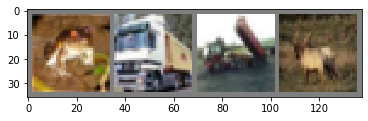

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))

In [ ]:
import time

In [4]:
import time
from boilerplate import Net, ResNet, evaluate_network_opt
start_nonrnn_sec = time.time()
perf_nonrnn, nonrnn = evaluate_network_opt(
    trainloader, holdoutloader, Net, common_kwargs_loader["batch_size"], step_size=480,epochs_desired=123)
end_nonrnn_sec = time.time()

Evaluating with num_batches/target num of batches:48001 / 48093
[1,   119] loss: 0.977

[1,   239] loss: 0.970

[1,   359] loss: 1.003

[2,    88] loss: 0.689

Progress: [####################] 100.0%
Evaluating with num_batches/target number of batches:48001 / 48093
Calculating AUC by class for num_batches/target number of batches:48001 / 48093


In [5]:
start_rnn_sec = time.time()
perf_rnn, rnn = evaluate_network_opt(
    trainloader, holdoutloader, ResNet, common_kwargs_loader["batch_size"], step_size=480,epochs_desired=123)
end_rnn_sec = time.time()

Evaluating with num_batches/target num of batches:48001 / 48093
[1,   119] loss: 0.067

[1,   239] loss: 0.078

[1,   359] loss: 0.099

[2,    88] loss: 0.054

Progress: [####################] 100.0%
Evaluating with num_batches/target number of batches:48001 / 48093
Calculating AUC by class for num_batches/target number of batches:48001 / 48093


In [ ]:
times = {"non_rnn_start": start_nonrnn_sec,
         "non_rnn_end": end_nonrnn_sec,
         "rnn_start": start_rnn_sec,
         "rnn_end": end_rnn_sec}

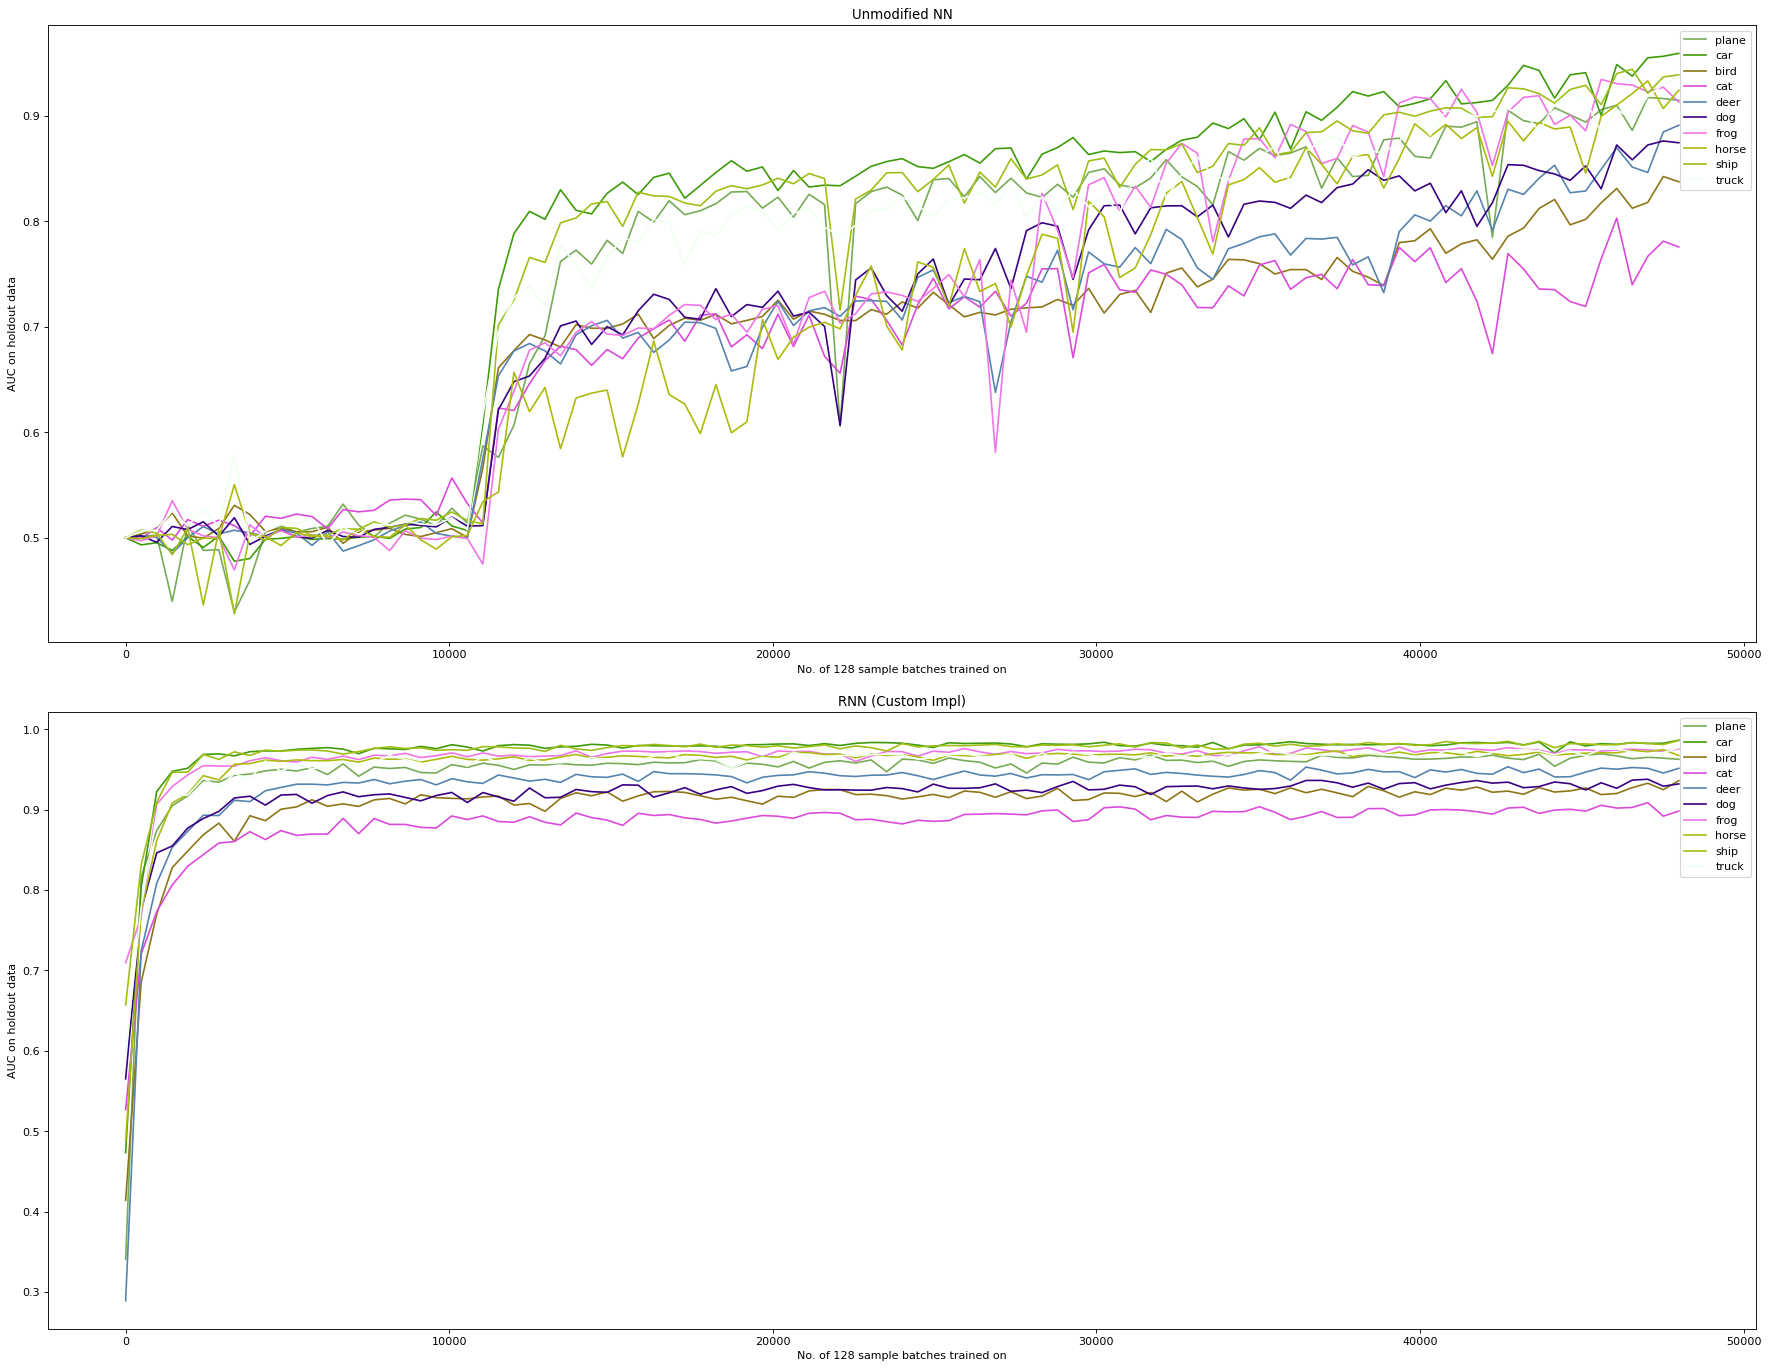

In [15]:
filtered = [list(filter(lambda x: x[1], perf_nonrnn.items())),
            list(filter(lambda x: x[1], perf_rnn.items()))]
import matplotlib.colors as colors
import random
random_colors = enumerate(random.sample(colors.get_named_colors_mapping().keys(), 10))
from matplotlib.pyplot import figure
def set_figsize(plots):
    fig, axs = plt.subplots(plots, 1, constrained_layout=True)
    fig.set_size_inches(11*plots, 8.5*plots)
    fig.dpi=80
    fig.facecolor="w"
    fig.edgecolor="k"
    return fig, axs
fig, axs = set_figsize(2)
for idx, title in enumerate([
    "Unmodified NN", 
    "RNN (Custom Impl)"], 0):
    axs[idx].set_title(title)
for idx in range(2):
    axs[idx].set_xlabel(f"No. of {common_kwargs_loader['batch_size']} sample batches trained on")
    axs[idx].set_ylabel(f"AUC on holdout data")
colors = {idx:c for idx, c in random_colors}
for label in range(0, 10):
    for idx in range(2):
        axs[idx].plot(list(map(lambda d: d[0], filtered[idx])), # x
                      list(map(lambda d: d[1][label], filtered[idx])), # auc for label
                      colors[label],
                      label=classes[label])
for idx in range(2):
    axs[idx].legend()
fig.savefig("C:\\Users\\v3nd3774\\.babun\\cygwin\\home\\v3nd3774\\ResidualNetwork\\comparison.png")
plt.show()

In [16]:
target_dir = "C:\\Users\\v3nd3774\\.babun\\cygwin\\home\\v3nd3774\\ResidualNetwork"
torch.save(rnn.state_dict(), f"{target_dir}\\rnn.pt")
torch.save(nonrnn.state_dict(), f"{target_dir}\\nonrnn.pt")

In [17]:
import pickle
with open(f"{target_dir}\\rnn_perf.dict", "wb") as f:
    pickle.dump(perf_rnn, f)
with open(f"{target_dir}\\nonrnn_perf.dict", "wb") as f:
    pickle.dump(perf_rnn, f)
with open(f"{target_dir}\\time_elapsed.dict", "wb") as f:
    pickle.dump(times, f)